In [32]:

import pandas as pd
from google.colab import files
dataset=files.upload()

Saving INR-vs-USD.csv to INR-vs-USD (4).csv


In [33]:
import numpy as np
dataset=pd.read_csv('INR-vs-USD.csv')

# Setting the date as the index
df = dataset.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
del df['Date']

#print(df.head(10))

# Interpolation
df_interpol = df.resample('D').mean()
df_interpol['INR vs USD'] = df_interpol['INR vs USD'].interpolate()

# Resetting index as [0,1...]
k=df_interpol.index
df_interpol.index = np.arange(0, len(df_interpol))
df_interpol = df_interpol.assign(Date = k) 
print(df_interpol)

       INR vs USD       Date
0        8.020000 1973-01-02
1        8.020000 1973-01-03
2        8.000000 1973-01-04
3        8.010000 1973-01-05
4        8.006667 1973-01-06
...           ...        ...
16302   64.100000 2017-08-21
16303   64.070000 2017-08-22
16304   64.040000 2017-08-23
16305   64.040000 2017-08-24
16306   64.000000 2017-08-25

[16307 rows x 2 columns]


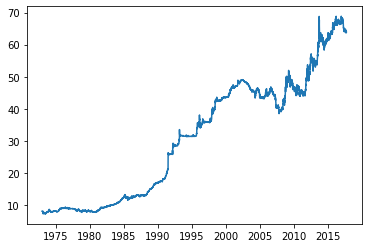

In [34]:
#original trend
import matplotlib.pyplot as plt

plt.plot(df_interpol["Date"],df_interpol['INR vs USD'])
# print(df_interpol)

In [35]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import numpy

def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

diff_values = difference(df_interpol['INR vs USD'].values)
print(diff_values)

0        0.000000
1       -0.020000
2        0.010000
3       -0.003333
4       -0.003333
           ...   
16301    0.000000
16302   -0.030000
16303   -0.030000
16304    0.000000
16305   -0.040000
Length: 16306, dtype: float64


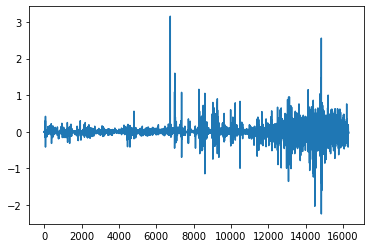

In [36]:
# stationarised values
plt.plot(diff_values)


In [37]:
def timeseries_to_supervised(data, n_steps):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, n_steps+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

n_steps=30
supervised = timeseries_to_supervised(diff_values, n_steps)
supervised_values = supervised.values
print(supervised_values)

[[        nan         nan         nan ...         nan         nan
   0.        ]
 [ 0.                 nan         nan ...         nan         nan
  -0.02      ]
 [-0.02        0.                 nan ...         nan         nan
   0.01      ]
 ...
 [-0.03        0.          0.         ... -0.01        0.00333333
  -0.03      ]
 [-0.03       -0.03        0.         ... -0.06       -0.01
   0.        ]
 [ 0.         -0.03       -0.03       ... -0.21       -0.06
  -0.04      ]]


In [38]:
train_size = int(len(df_interpol) * 0.80)
train, test = supervised_values[0:train_size], supervised_values[train_size:]
print(train.shape,test.shape)

(13045, 31) (3261, 31)


In [39]:
print(train[30:])

[[ 0.          0.         -0.01       ... -0.02        0.
   0.        ]
 [ 0.          0.          0.         ...  0.01       -0.02
  -0.01      ]
 [-0.01        0.          0.         ... -0.00333333  0.01
  -0.01      ]
 ...
 [-0.65        0.88        0.10333333 ...  0.1         0.02
   0.2       ]
 [ 0.2        -0.65        0.88       ... -0.18        0.1
  -0.65      ]
 [-0.65        0.2        -0.65       ... -0.11       -0.18
  -0.13666667]]


In [0]:
def scale(train, test):

	scaler = MinMaxScaler(feature_range=(-1, 1))
 
	scaler = scaler.fit(train)

	train = train.reshape(train.shape[0], train.shape[1])
 
	train_scaled = scaler.transform(train)

	test = test.reshape(test.shape[0], test.shape[1])
 
	test_scaled = scaler.transform(test)
 
	return scaler, train_scaled, test_scaled

scaler, train_scaled, test_scaled = scale(train[30:], test)

In [41]:
print(train_scaled)

[[-0.46635731 -0.46635731 -0.47099768 ... -0.47563805 -0.46635731
  -0.46635731]
 [-0.46635731 -0.46635731 -0.46635731 ... -0.46171694 -0.47563805
  -0.47099768]
 [-0.47099768 -0.46635731 -0.46635731 ... -0.4679041  -0.46171694
  -0.47099768]
 ...
 [-0.76798144 -0.05800464 -0.41840681 ... -0.4199536  -0.45707657
  -0.37354988]
 [-0.37354988 -0.76798144 -0.05800464 ... -0.54988399 -0.4199536
  -0.76798144]
 [-0.76798144 -0.37354988 -0.76798144 ... -0.51740139 -0.54988399
  -0.52977572]]


In [42]:
# model architecture - used stochastic gradient descent
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	model.fit(X,y,epochs=nb_epoch,batch_size=batch_size,verbose=1)
	return model

lstm_model = fit_lstm(train_scaled, 1, 5, 100)

Epoch 1/5
13015/13015 [==============================] - 37s 3ms/step - loss: 0.0020
Epoch 2/5
13015/13015 [==============================] - 37s 3ms/step - loss: 0.0016
Epoch 3/5
13015/13015 [==============================] - 37s 3ms/step - loss: 0.0015
Epoch 4/5
13015/13015 [==============================] - 37s 3ms/step - loss: 0.0015
Epoch 5/5
13015/13015 [==============================] - 37s 3ms/step - loss: 0.0015


In [0]:
#NORMAL FORECASTING USING LSTM
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]



In [44]:
predictions = list()
actual_y=list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	# print(X.shape)
	yhat = forecast_lstm(lstm_model, 1, X)
	# yhat=y
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(df_interpol['INR vs USD'].values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = df_interpol['INR vs USD'].values[len(train) + i + 1]
	actual_y.append(expected)
	print(' Predicted=%f , actual %f' % (yhat,expected))

 Predicted=45.542913 , actual 45.436667
 Predicted=45.435011 , actual 45.300000
 Predicted=45.322977 , actual 45.650000
 Predicted=45.608452 , actual 45.920000
 Predicted=45.965296 , actual 46.080000
 Predicted=46.049700 , actual 46.480000
 Predicted=46.498375 , actual 46.483333
 Predicted=46.512543 , actual 46.486667
 Predicted=46.479846 , actual 46.490000
 Predicted=46.512522 , actual 46.450000
 Predicted=46.419066 , actual 46.470000
 Predicted=46.483868 , actual 46.630000
 Predicted=46.614497 , actual 47.010000
 Predicted=47.011814 , actual 47.263333
 Predicted=47.266438 , actual 47.516667
 Predicted=47.504795 , actual 47.770000
 Predicted=47.782141 , actual 47.780000
 Predicted=47.765067 , actual 48.000000
 Predicted=48.023015 , actual 48.000000
 Predicted=47.996874 , actual 48.410000
 Predicted=48.392045 , actual 48.290000
 Predicted=48.312401 , actual 48.170000
 Predicted=48.158336 , actual 48.050000
 Predicted=48.054525 , actual 47.930000
 Predicted=47.919710 , actual 48.530000


In [45]:
# report performance
rmse = sqrt(mean_squared_error(actual_y[0:-1], predictions[1:]))
print('Test RMSE: %f' % rmse)

Test RMSE: 0.015070


In [46]:
print(test_scaled)

[[-0.52977572 -0.76798144 -0.37354988 ... -0.41067285 -0.51740139
  -0.52977572]
 [-0.52977572 -0.52977572 -0.76798144 ... -0.41067285 -0.41067285
  -0.52977572]
 [-0.52977572 -0.52977572 -0.52977572 ... -0.41067285 -0.41067285
  -0.30394432]
 ...
 [-0.48027842 -0.46635731 -0.46635731 ... -0.47099768 -0.46481052
  -0.48027842]
 [-0.48027842 -0.48027842 -0.46635731 ... -0.49419954 -0.47099768
  -0.46635731]
 [-0.46635731 -0.48027842 -0.48027842 ... -0.5638051  -0.49419954
  -0.48491879]]


In [47]:
#ROLLING FORECASTING PART

rolling_forecast_result=list()
actual_result=list()
X=test_scaled[0, 0:-1]
initial_x=X
print(initial_x.shape)
initial_y=forecast_lstm(lstm_model,1,initial_x)





for i in range(1,len(test_scaled)):
	# make one-step forecast
	X= X[1:]
	X=numpy.append(X,initial_y)
	y=test_scaled[i,-1]
	# X.append(initial_y)
	# X=numpy.append(X,initial_y) 
	# print(X.shape)
	yhat = forecast_lstm(lstm_model, 1, X)
	initial_y=yhat
	# yhat=y
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(df_interpol['INR vs USD'].values, yhat, len(test_scaled)+1-i)
	# store forecast
	rolling_forecast_result.append(yhat)
	expected = df_interpol['INR vs USD'].values[len(train) + i + 1]
	actual_result.append(expected)


	print(' rolling forecast =%f , actual %f' % (yhat,expected))

(30,)
 rolling forecast =45.457404 , actual 45.300000
 rolling forecast =45.253577 , actual 45.650000
 rolling forecast =45.703807 , actual 45.920000
 rolling forecast =45.885456 , actual 46.080000
 rolling forecast =46.082867 , actual 46.480000
 rolling forecast =46.473630 , actual 46.483333
 rolling forecast =46.480379 , actual 46.486667
 rolling forecast =46.494241 , actual 46.490000
 rolling forecast =46.479907 , actual 46.450000
 rolling forecast =46.462483 , actual 46.470000
 rolling forecast =46.443308 , actual 46.630000
 rolling forecast =46.632101 , actual 47.010000
 rolling forecast =46.997482 , actual 47.263333
 rolling forecast =47.259305 , actual 47.516667
 rolling forecast =47.534008 , actual 47.770000
 rolling forecast =47.733020 , actual 47.780000
 rolling forecast =47.791562 , actual 48.000000
 rolling forecast =47.993530 , actual 48.000000
 rolling forecast =47.994293 , actual 48.410000
 rolling forecast =48.414026 , actual 48.290000
 rolling forecast =48.264029 , act

In [49]:
# report performance

rmse = sqrt(mean_squared_error(rolling_forecast_result[1:], actual_result[0:-1]))
# rmse = sqrt(mean_squared_error(actual_y[0:-1], predictions[1:]))
print('Test RMSE: %f' % rmse)

Test RMSE: 0.007879
